In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math
from scipy.cluster.hierarchy import fcluster, linkage
from collections import defaultdict
from tqdm import tqdm
from utils import base_model
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision import ops
from torchvision.models import resnet18
import torch.nn as nn

In [2]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                               ])

In [3]:
# model = base_model(2)
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

ckpt = torch.load('context_model_resnet18_best_2810.pt',map_location='cpu')
model.load_state_dict(ckpt['model'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
data = [json.loads(l) for l in open('/mnt/ssd1/hang/MaskDINO/notebooks/demo_mask_images/SIA-cases-maskdino_wheel-body_predictions_full_version.json').readlines()]
len(data)

197

In [5]:
def cluster_boxes_func(boxes): # xywh
#     dis = 
    box_centers = np.array([(x1/2 + x2 / 2, y1/2 + y2 / 2) for x1, y1, x2, y2 in boxes])

    distance_threshold = max([b[2]-b[0] for b in boxes] + [b[3]-b[1] for b in boxes])  # Maximum distance to consider boxes in the same cluster
    Z = linkage(box_centers, method='single', metric='euclidean')
    cluster_labels = fcluster(Z, t=distance_threshold, criterion='distance')

    # Group box indices by cluster labels
    clusters = {}
    for idx, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(idx)  # Append index of the box
    
    return clusters
def refine_box_coord(boxes, image):#box: xyxy
    img_h, img_w = image.shape[:2]
    boxes = np.array(boxes)
    
    boxes[:,0][boxes[:,0] < 0] = 0
    boxes[:,1][boxes[:,1] < 0] = 0
    boxes[:,2][boxes[:,2] > img_w] = img_w
    boxes[:,3][boxes[:,3] > img_h] = img_h
    return boxes

def plot_box(img, box, c=(255,255,0), thickness=10):
    box = np.array(box)
#     print(box.ndim)
    if box.ndim > 1:
        for b in box:
            img = cv2.rectangle(img, b[0:2], b[2:], c, thickness)
    else:
        img = cv2.rectangle(img, box[0:2], box[2:], c, thickness)
    return img
def get_bounding_box(boxes):
    """
    Calculate the bounding box that encloses two boxes.

    Parameters:
    box1 (tuple): Coordinates of the first box (x1, y1, x2, y2).
    box2 (tuple): Coordinates of the second box (x1, y1, x2, y2).

    Returns:
    tuple: Coordinates of the bounding box (x_min, y_min, x_max, y_max).
    """
    boxes = np.array(boxes)
#     print('boxes:',boxes)
    x_min = np.min(boxes[:,0])
    y_min = np.min(boxes[:,1])
    x_max = np.max(boxes[:,2])
    y_max = np.max(boxes[:,3])

    return [x_min, y_min, x_max, y_max]
def check_box_on_img_boundary(image, box):
    img_h, img_w = image.shape[0:2]
    p1 = [box[0], box[1]]
    p2 = [box[2], box[1]]
    p3 = [box[2], box[3]]
    p4 = [box[0], box[3]]
    points = np.array([p1,p2,p3,p4])
#     print(points[:,0])
#     print('---',np.any(points[:,0]<=0))
#     print('---',np.any(points[:,0]>=img_w))
#     print('---',np.any(points[:,1]<=0))
#     print('---',np.any(points[:,1]>=img_h))
    sum_bound = np.sum(np.array([np.any(points[:,0]<=0),
                np.any(points[:,0]>=img_w),
                np.any(points[:,1]<=0),
                np.any(points[:,1]>=img_h)]))
#     print('sum bound:', sum_bound)
    return sum_bound
def get_enlarge_body_box(img, box):
    body_w = box[2]-box[0]
    body_h = box[3]-box[1]
    new_x1 = box[0]-int(body_w/10)
    new_y1 = box[1]-int(body_h/10)
    new_x2 = box[2]+int(body_w/10)
    new_y2 = box[3]+int(body_h/10)
    new_box = [new_x1,new_y1,new_x2,new_y2]
    new_box = refine_box_coord([new_box], img)[0]
    return new_box

def split_equal_patches(box, scales):
    w = box[2]-box[0]
    h = box[3]-box[1]
    
    patches_all_scales = []
    for k in scales:
        x_unit = w/k[0]
        y_unit = h/k[1]

        list_x = []
        list_y = []
        for i in range(0, k[0]+1, 1):
            list_x.append(box[0]+ i* x_unit)
        for i in range(0, k[1]+1, 1):
            list_y.append(box[1]+ i* y_unit)


        patches = []
        for y_i in range(0, len(list_y)-1,1):
            for x_i in range(0, len(list_x)-1,1):
                start_point = [list_x[x_i], list_y[y_i]]
                end_point = [list_x[x_i+1], list_y[y_i+1]]
                point = start_point+end_point
                patches.append(point)
        patches = np.array(patches).astype('i')
        patches_all_scales.append(patches)
        
#         print(patches)
    
    return patches_all_scales

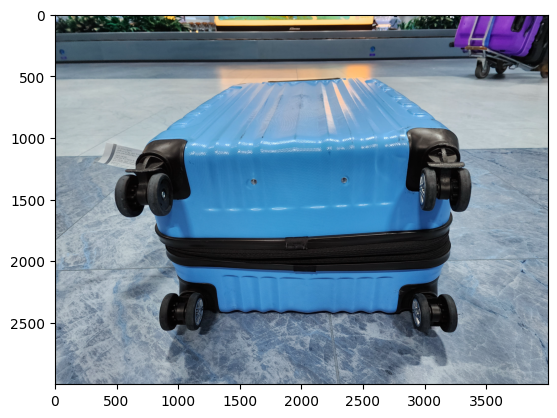

In [101]:
image = cv2.imread(t_data['img_path'])
plt.imshow(image)
plt.show()

wheel_boxes [[2502 3621 2613 3843]
 [2361 3642 2451 3833]
 [ 676 3609  741 3699]]
body_boxes [[ 499  677 2672 3689]]
wheel_scores: [0.72022486 0.61934692 0.48245779]


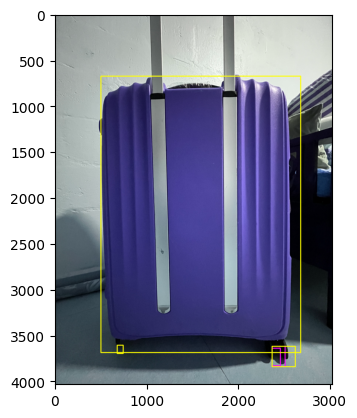

In [121]:
t_data = data[10]
image = cv2.imread(t_data['img_path'])
body_boxes = np.array(t_data['body_box']).astype('i')
body_scores = np.array(t_data['body_scores'])

wheel_scores = np.array(t_data['wheel_scores'])
wheel_boxes = np.array(t_data['wheel_box']).astype('i')
print('wheel_boxes',wheel_boxes)
print('body_boxes',body_boxes)
print('wheel_scores:',wheel_scores)

# cluster double wheel
if len(body_boxes) > 1:
    body_clusters = cluster_boxes_func(body_boxes)
elif len(body_boxes)==1:
    body_clusters = {1: [0]}
# else:
#     continue
#     print('body_clusters:',body_clusters)
group_body_boxes = []
for grp, ids in body_clusters.items():
    bbox = get_bounding_box(body_boxes[ids])
    group_body_boxes.append(bbox)

main_body_id = max(range(len(group_body_boxes)), key=lambda i: (group_body_boxes[i][2]-group_body_boxes[i][0])*(group_body_boxes[i][3]-group_body_boxes[i][1]))
main_body = group_body_boxes[main_body_id]

# cluster double wheel
if len(wheel_boxes) > 1:
    clusters = cluster_boxes_func(wheel_boxes)
else:
    clusters = {1: [0]}
#     print('clusters:',clusters)
group_wheel_boxes = []
group_scores = []
for grp, ids in clusters.items():
    bbox = get_bounding_box(wheel_boxes[ids])
#         print('bbox:',bbox)
    score = np.max(wheel_scores[ids])

    group_wheel_boxes.append(bbox)
    group_scores.append(score)

group_wheel_boxes = refine_box_coord(group_wheel_boxes, image)

image = plot_box(image, wheel_boxes, (255,0,255))
image = plot_box(image, main_body)
image = plot_box(image, group_wheel_boxes) # group_wheel_boxes+main_body)

plt.imshow(image)
plt.show()

main_body: [499, 677, 2672, 3689]
body_on_boundary: 0
body_wh 2173 3012
scales: [array([2, 2]), array([3, 3]), array([4, 4]), array([1, 2]), array([2, 3])]
5


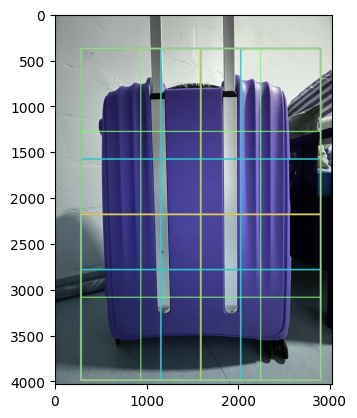

In [115]:
image = cv2.imread(t_data['img_path'])
# image = cv2.imread('/data2/thang/SIA/ScaledYOLO/inference/wheel-missing-wheel-v2/SINSQ77343_SQ666377_SINSQ77343_24112023_MotionsCloud_SQ666377_bottom_6TM4T5SQ666377bottom.jpeg')
# main_body = [0,0, image.shape[1], image.shape[0]]

print('main_body:',main_body)
body_on_boundary = check_box_on_img_boundary(image, main_body)
# body_on_boundary = 0
print('body_on_boundary:',body_on_boundary)

scales = []
body_w = main_body[2]-main_body[0]
body_h = main_body[3]-main_body[1]
print('body_wh',body_w, body_h)
if body_on_boundary == 0:
    
    scale0 = np.array([2,2])
    scales.append(scale0)
    scale1 = scale0+1
    scales.append(scale1)
    scale2 = scale1+1
    scales.append(scale2)
    
    scale3 = np.array((1,2)) if body_w < body_h else np.array((2,1))
    scales.append(scale3)
    scale4 = scale3+1
    scales.append(scale4)
elif body_on_boundary>=1:
    
    scale0 = np.array([1,1])
    scales.append(scale0)
    scale1 = scale0+1
    scales.append(scale1)
    
    scale2 = np.array((1,2)) if body_w < body_h else np.array((2,1))
    scales.append(scale2)
    scale3 = scale2+1
    scales.append(scale3)
    scale4 = scale3+1
    scales.append(scale4)

print('scales:',scales)


outer_box = get_enlarge_body_box(image, main_body)
# print('outer_box',outer_box)
patches_all_scales = split_equal_patches(outer_box, scales)
print(len(patches_all_scales))
image = plot_box(image, outer_box)
for i, p in enumerate(patches_all_scales):
    color = tuple(np.random.randint(0, 255, size=(3, )).tolist())    
    image = plot_box(image, p, color, 20-5*i)

plt.imshow(image)
plt.show()

In [73]:
1655/224

7.388392857142857

In [122]:
image = cv2.imread(t_data['img_path'])
# image = cv2.imread('/data2/thang/SIA/ScaledYOLO/inference/wheel-missing-wheel-v2/SINSQ77343_SQ666377_SINSQ77343_24112023_MotionsCloud_SQ666377_bottom_6TM4T5SQ666377bottom.jpeg')

threshold = 0.5

outer_box = get_enlarge_body_box(image, main_body)
patches_all_scales = split_equal_patches(outer_box, scales)
patches_all_scales = np.concatenate(patches_all_scales)

list_tensor = []
for patch in patches_all_scales:
    crop = image[patch[1]:patch[3],patch[0]:patch[2]]
    pil_crop = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    list_tensor.append(transform(pil_crop))

patches_tensor = torch.stack(list_tensor)
print('patches_tensor')
print(patches_tensor.shape)
output = torch.softmax(model(patches_tensor),dim=1)

# print('output:',output)
labels = output.max(1)[1]
labels = torch.where(output[:, 0] < threshold, 1, torch.argmax(output, dim=1))
print('labels',labels)
confs = output[labels.detach().numpy() == 1][:,1]
print('confs',confs)
boxes = patches_all_scales[labels.detach().numpy() == 1]
negboxes = patches_all_scales[labels.detach().numpy() == 0]

# boxes = patches_all_scales[confs.detach().numpy() > 0.6]

ids = ops.nms(torch.tensor(boxes,dtype=torch.float),confs,0.3)
print(ids)
print(confs[ids])
# print(boxes[ids])

patches_tensor
torch.Size([37, 3, 224, 224])
labels tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1])
confs tensor([0.9503, 0.9880, 0.5101, 0.8898, 0.6361, 0.9616, 0.9786, 0.9880],
       grad_fn=<SelectBackward>)
tensor([7, 6])
tensor([0.9880, 0.9786], grad_fn=<IndexBackward>)


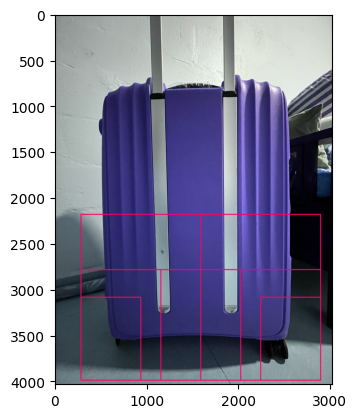

In [118]:
image = cv2.imread(t_data['img_path'])
# image = cv2.imread('/data2/thang/SIA/ScaledYOLO/inference/wheel-missing-wheel-v2/SINSQ77343_SQ666377_SINSQ77343_24112023_MotionsCloud_SQ666377_bottom_6TM4T5SQ666377bottom.jpeg')

plt.imshow(plot_box(image,boxes,(255,0,100)))

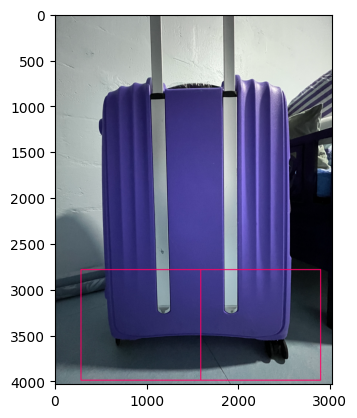

In [119]:
image = cv2.imread(t_data['img_path'])
# image = cv2.imread('/data2/thang/SIA/ScaledYOLO/inference/wheel-missing-wheel-v2/SINSQ77343_SQ666377_SINSQ77343_24112023_MotionsCloud_SQ666377_bottom_6TM4T5SQ666377bottom.jpeg')

plt.imshow(plot_box(image,boxes[ids],(255,0,100)))

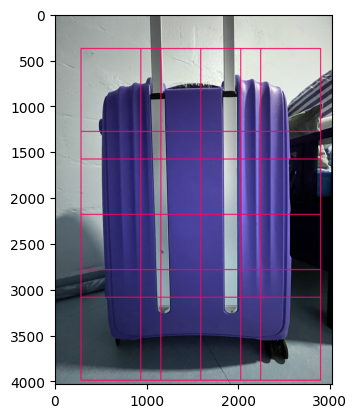

In [120]:
image = cv2.imread(t_data['img_path'])

plt.imshow(plot_box(image,negboxes,(255,0,100)))